In [56]:
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.circuit.library import *
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, pauli_error, mixed_unitary_error, depolarizing_error)

The following is how we can use `DensityMatrix` class from the `quantum_info` module to construct density matrices:

In [57]:
l = qi.DensityMatrix.from_label('l')
r = qi.DensityMatrix.from_label('r')
p = qi.DensityMatrix.from_label('+')

rho = 8/10*r + 1/10*l + 1/10*p
rho.draw('latex')

<IPython.core.display.Latex object>

Now, we use `mixed_unitary_error` to define a faulty gate as follows

In [58]:
S = qi.Operator.from_label('S')
Sdg = S.adjoint()
I = qi.Operator.from_label('I')

prob_S = 0.8
prob_Sdg = 0.1
prob_I = 0.1

S_noisy = mixed_unitary_error([(S,prob_S),(Sdg,prob_Sdg),(I,prob_I)])
print(S_noisy)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.8, Circuit = 
   ┌─────────┐
q: ┤ Unitary ├
   └─────────┘
  P(1) = 0.1, Circuit = 
   ┌─────────┐
q: ┤ Unitary ├
   └─────────┘
  P(2) = 0.1, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


We can define a noise model and add our faulty gate to it using `NoiseModel` and `add_quantum_error`

In [59]:
noise_m = NoiseModel()
noise_m.add_quantum_error(S_noisy,['id'],[0])
print(noise_m)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['id']
  Qubits with noise: [0]
  Specific qubit errors: [('id', (0,))]


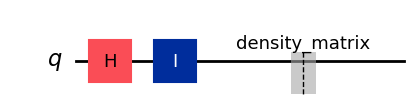

In [60]:
# Define a circuit

qc = QuantumCircuit(1)
qc.h(0)
qc.id(0)

# Save the density matrix so that we can obtain it later
qc.save_density_matrix()
qc.draw(output = 'mpl')

Now we use the `AerSimulator` to run pur circuit and we give it the `NoiseModel` instance we defined

In [61]:
sim_density = AerSimulator(noise_model = noise_m )
job = sim_density.run(qc)
result = job.result().data()
rhos = result.get('density_matrix')
rhos.draw('latex')

<IPython.core.display.Latex object>

The following demonstrates different ways to create errors in qiskit

In [62]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'reset', 'measure', 'u2', 'cx', 'u1']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


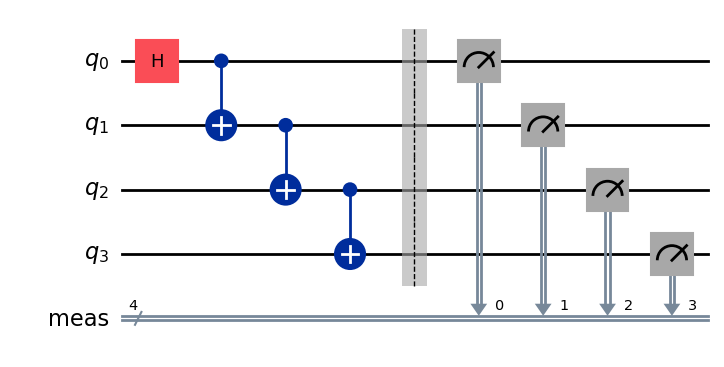

In [63]:
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
circ.draw(output = 'mpl')

In [85]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_noise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_noise).result()
counts_bit_flip = result_bit_flip.get_counts()
print(counts_bit_flip)

{'0000': 248, '1011': 40, '0001': 55, '1111': 262, '0101': 17, '1110': 55, '0011': 27, '0111': 50, '1000': 52, '1101': 51, '1100': 26, '0010': 50, '0100': 37, '0110': 19, '1010': 17, '1001': 18}


## Section 2: Error Correcting

Here we show how to implement the circuit for Shor's 9 qubit error correccting scheme

First we define the noise model:

In [65]:
# Define the noise model
def noise():
    i_error = depolarizing_error(0.3, 1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(i_error, "i_with_error")
    return noise_model

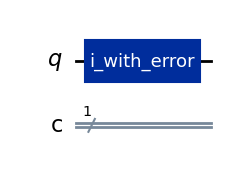

In [66]:
# Define the noisy gate
def noise_circuit():
    # Measuring for demostration purposes
    qc = QuantumCircuit(1,1)
    i_gate = IGate(label="i_with_error")
    qc.append(i_gate, [0])
    return qc

# Draw the resulting circuit
noise_circuit().draw('mpl')

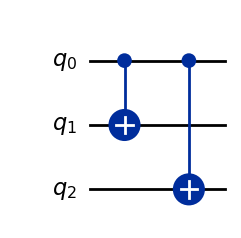

In [67]:
# 3 qubit encoding circuit
def encoding_circuit():
    qc = QuantumCircuit(3)
    qc.cx(0,1)
    qc.cx(0,2)
    return qc

# Draw the resulting circuit
encoding_circuit().draw('mpl')

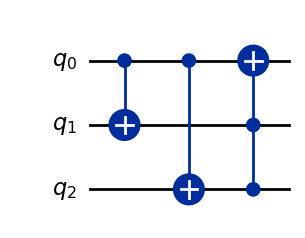

In [68]:
# 3 qubit decoding circuit
def decoding_circuit():
    qc = QuantumCircuit(3)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.ccx(2, 1, 0)   
    return qc

# Draw the resulting circuit
decoding_circuit().draw('mpl')

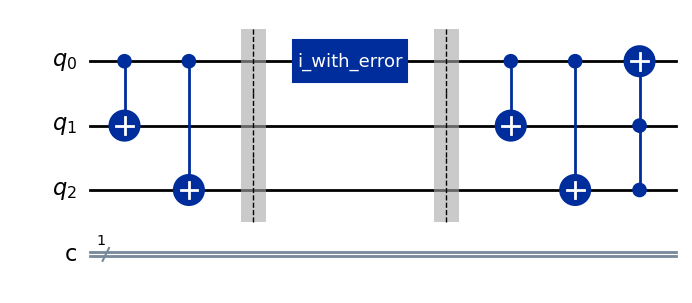

In [69]:
# 3 qubit bit flip correcting circuit
def bit_correcting_circuit():
    
    # Ecode the qubits
    qc = encoding_circuit()
    
    qc.barrier()
    
    # Compose with the noise circuit
    qc = qc.compose(noise_circuit(), 0)
    
    qc.barrier()
    
    # Compose with the decoding circuit
    qc = qc.compose(decoding_circuit(), [0,1,2])

    return qc

# Draw the resulting circuit
bit_correcting_circuit().draw('mpl')

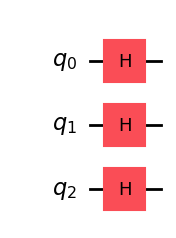

In [70]:
# 3 qubit hadamard addition
def phase_correction():
    qc = QuantumCircuit(3)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    return qc

# Draw the resulting circuit
phase_correction().draw('mpl')

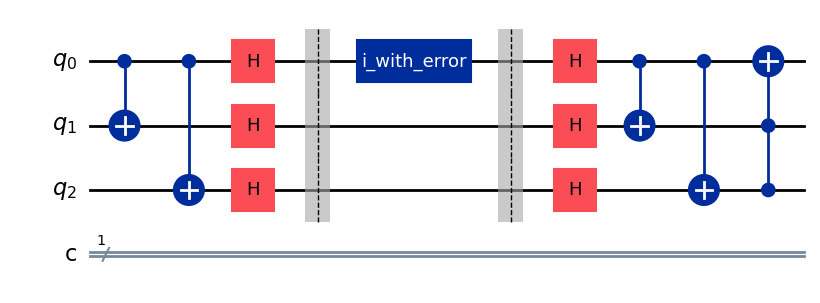

In [71]:
# 3 qubit phase correcting circuit
def phase_correcting_circuit():
        
    # Ecode the qubits
    qc = encoding_circuit()
    
    # Apply phase corrections
    qc = qc.compose(phase_correction(), [0,1,2])
    
    qc.barrier()
    
    # Compose with the noise circuit
    qc = qc.compose(noise_circuit(), 0)
    
    qc.barrier()
    
    # Apply phase corrections
    qc = qc.compose(phase_correction(), [0,1,2])
    
    # Compose with the decoding circuit
    qc = qc.compose(decoding_circuit(), [0,1,2])

    return qc

# Draw the resulting circuit
phase_correcting_circuit().draw('mpl')

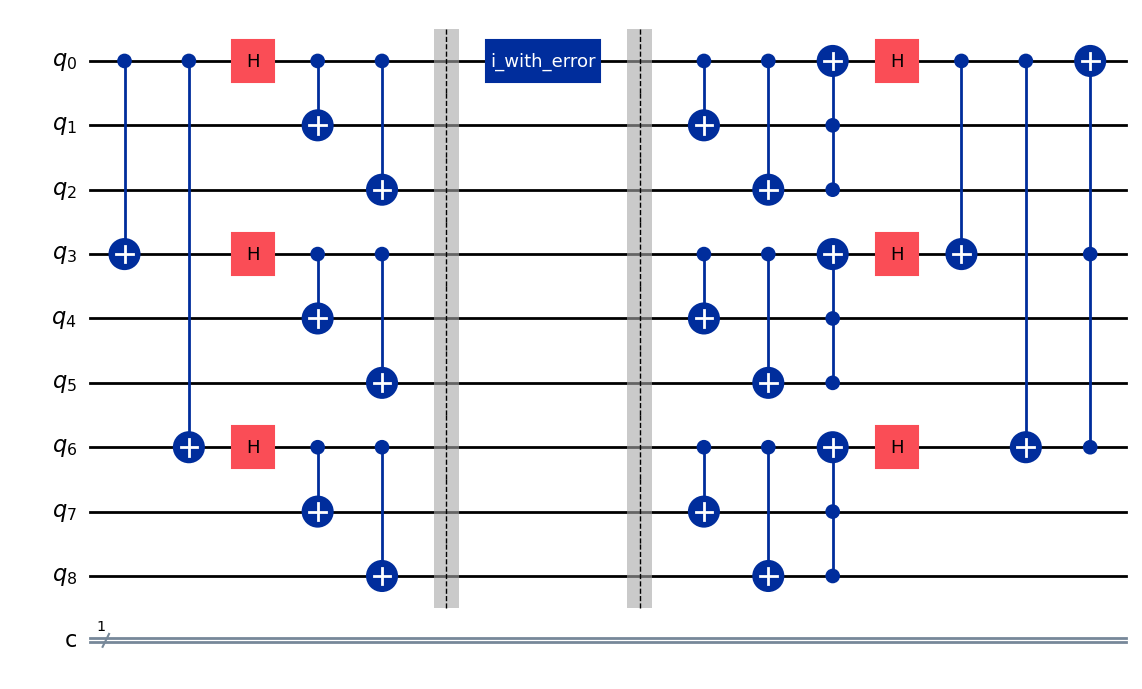

In [72]:
def error_correcting_circuit():
    qc = QuantumCircuit(9)
    
    qc = qc.compose(encoding_circuit(), [0,3,6])
    qc = qc.compose(phase_correction(), [0,3,6])
    
    qc = qc.compose(encoding_circuit(), [0,1,2])
    qc = qc.compose(encoding_circuit(), [3,4,5])
    qc = qc.compose(encoding_circuit(), [6,7,8])
    
    qc.barrier()
    qc = qc.compose(noise_circuit(), [0])
    qc.barrier()

    
    qc = qc.compose(decoding_circuit(), [0,1,2])
    qc = qc.compose(decoding_circuit(), [3,4,5])
    qc = qc.compose(decoding_circuit(), [6,7,8])
        
    qc = qc.compose(phase_correction(), [0,3,6])
    qc = qc.compose(decoding_circuit(), [0,3,6])
    
    return qc

# Draw the resulting circuit
error_correcting_circuit().draw('mpl')

In [73]:
# Simulate the results without error correction
qc_error = noise_circuit()
qc_error.measure(0,0)
sim = AerSimulator(noise_model = noise())
result = sim.run(qc_error).result()

print("Measuring the first qubit with error correction: ", result.get_counts())


# Simulate the results with error correction
qc = error_correcting_circuit()
qc.measure(0,0)
sim = AerSimulator(noise_model = noise())
result = sim.run(qc).result()

print("Measuring the first qubit with error correction: ", result.get_counts())

Measuring the first qubit with error correction:  {'0': 871, '1': 153}
Measuring the first qubit with error correction:  {'0': 1024}
